In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

Set *Axlmutants_Erl_F154* or *Axlmutants_Erl* to **True** in order to use these data.

In [3]:
ABC = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T
info = ABC.iloc[:, :6]

### Phenotypes

#### Cell Viability (from luminex...):

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv')
# Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv').T

Y_cv = Y_cv.iloc[:, 0:10].div(Y_cv.iloc[:, 0], axis=0).T

# Y_cv = Y_cv.iloc[:, 0:10].sub(Y_cv.iloc[:, 0:10].mean(axis=1), axis=0).T

# Chained MS mixed clustering + PLSR analysis

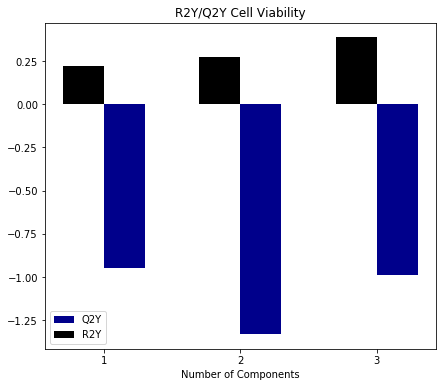

In [5]:
ncl = 3
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [7]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial")), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

In [8]:
# fig, ax = plt.subplots(1,1,figsize=(6,5))
# plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

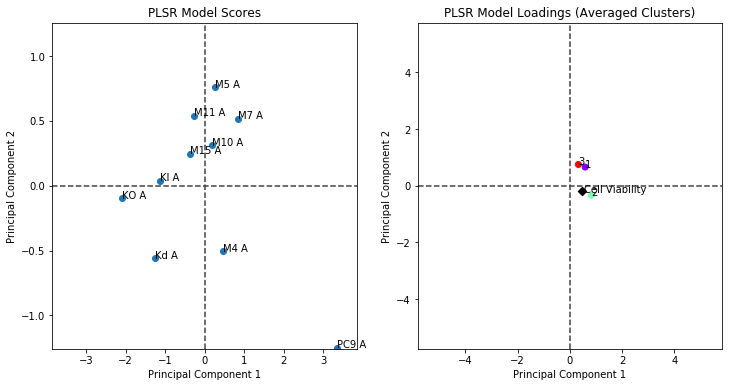

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [10]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2,Cluster_3,seqs_Cluster_3,UniprotAcc_Cluster_3,pos_Cluster_3,r2/Std_Cluster_3,BioReps_Cluster_3
0,40S ribosomal protein SA ; RPSA,LTEASyVNLPT,P08865,Y139-p,NA,1,Activated CDC42 kinase 1 ; TNK2,VKKPTyDPVSE,Q07912,Y518-p,NA,1,Breast cancer anti-estrogen resistance protein 3 ; BCAR3,DPTVEyVKFSK,O75815,Y117-p,0.95,2
1,60S ribosomal protein L10a ; RPL10A,SRDTLyEAVRE,P62906,Y11-p,NA,1,Annexin A2 ; ANXA2,GKsLYyYIQQD,P07355,Y317-p,NA,1,Caveolin-1 ; CAV1,MSGGKyVDSEG,Q03135,Y6-p,NA,1
2,Abl interactor 2 ; ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1,Annexin A2 ; ANXA2,KsYSPyDMLES,P07355,Y238-p,0.85,2,Cell surface glycoprotein MUC18 ; MCAM,DQGEKyIDLRH,P43121,Y641-p,NA,1
3,Afadin ; AFDN,TYTREyFTFPA,P55196,Y1230-p,NA,1,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1 ; BAIAP2L1,VVRKDyDTLSK,Q9UHR4,Y274-p,NA,1,Cyclin-dependent kinase-like 5 ; CDKL5,ANYTEyVATRW,O76039,Y171-p,NA,1
4,Alpha-actinin-1 ; ACTN1,DVAEKyLDIPK,P12814,Y215-p,NA,1,Catenin delta-1 ; CTNND1,GGSDNyGSLSR,O60716,Y228-p,NA,1,Cysteine-rich protein 1 ; CRIP1,CNKEVyFAERV,P50238,Y12-p,NA,1
5,Annexin A1 ; ANXA1,DARALyEAGER,P04083,Y207-p,NA,1,Clathrin heavy chain 1 ; CLTC,ITEEDyQALRT,Q00610,Y1477-p,NA,1,Desmoplakin ; DSP,QPELKyGDGIQ,P15924,Y95-p,NA,1
6,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1 ; ARAP1",FDDSDyDEVPE,Q96P48,Y231-p,NA,1,Crk-like protein ; CRKL,RVPCAyDKTAL,P46109,Y251-p,NA,1,Eukaryotic translation initiation factor 2 subunit 2 ; EIF2S2,KDTRLyFLQCE,P20042,Y298-p,NA,1
7,BAG family molecular chaperone regulator 3 ; BAG3,AQQGEyQTHQP,O95817,Y240-p,NA,1,Cyclin-dependent kinase 1 ; CDK1,IGEGTyGVVYK,P06493,Y15-p,0.99,2,Glycosaminoglycan xylosylkinase ; FAM20B,VEGEPyAGYDR,O75063,Y138-p,NA,1
8,Band 4.1-like protein 1 ; EPB41L1,IRPGEyEQFES,Q9H4G0,Y343-p,NA,1,Cyclin-dependent kinase 2 ; CDK2,IGEGTyGVVYK,P24941,Y15-p,0.47,3,"Keratin, type I cytoskeletal 18 ; KRT18",TFSTNyRSLGS,P05783,Y13-p,NA,1
9,Band 4.1-like protein 2 ; EPB41L2,EGDNIyVRHSN,O43491,Y623-p,0.68,2,Cyclin-dependent kinase 2 ; CDK2,IGEGtyGVVYK,P24941,Y15-p,NA,1,Mitogen-activated protein kinase 1 ; MAPK1,GFLTEyVATRW,P28482,Y187-p,NA,1


In [11]:
create_download_link(clustermembers, "DataClustering")

TypeError: plotclusteraverages() missing 1 required positional argument: 'ncl'

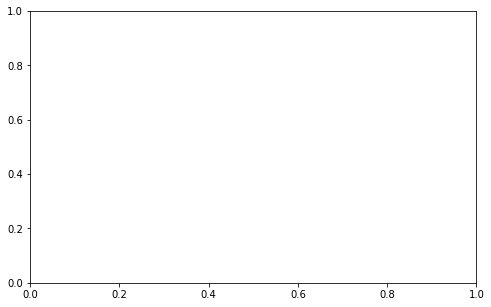

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr)